# CARREGAR AS ANOTAÇÕES DO XML E RECORTAR AS IMAGENS

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [2]:
import os
import numpy as np # linear algebra
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET


with open('/home/pedrodsk/datasets/dataset2/PKLot/UFPR04/Sunny/2012-12-07/2012-12-07_19_02_27.xml') as annot_file:
    print(''.join(annot_file.readlines()))

In [8]:
BASE_PATH = ['../..','datasets']

DATASET_DIR = os.path.join(BASE_PATH[0],BASE_PATH[1],'PKLot')

path = '/PKLot/UFPR04/Sunny/2012-12-07'
path = os.path.normpath(path)
path = path.split(os.sep)

IMAGE_DIR = os.path.join(DATASET_DIR,path[2],path[3],path[4])
IMAGE_FILE = '2012-12-07_19_02_27.jpg'
IMAGE_PATH = os.path.join(IMAGE_DIR, IMAGE_FILE)

XML_DIR = IMAGE_DIR
XML_FILE = '2012-12-07_19_02_27.xml'
XML_PATH = os.path.join(XML_DIR, XML_FILE)

#debug
print(IMAGE_PATH)
print(XML_PATH)

../../datasets/PKLot/UFPR04/Sunny/2012-12-07/2012-12-07_19_02_27.jpg
../../datasets/PKLot/UFPR04/Sunny/2012-12-07/2012-12-07_19_02_27.xml


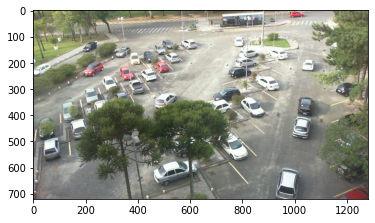

In [9]:
image = plt.imread(IMAGE_PATH)
plt.imshow(image)

## Carrega o XML e filtra os pontos X e Y.

In [10]:
tree = ET.parse(os.path.join(XML_DIR,XML_FILE))
root = tree.getroot()

pts = np.empty(0,np.int32)
vaga = np.empty(0,np.int32)

for neighbor in root.iter('point'):
    #print(neighbor.attrib)
    x,y = neighbor.attrib.values()
    x = int(x)
    y = int(y)
    a = [x,y]
    pts = np.append(pts,[x,y])
    
for neighbor in root.iter('space'):
    #print(neighbor.attrib)
    id2,occupied = neighbor.attrib.values()
    occupied = int(occupied)
    vaga = np.append(vaga,occupied)

#debug
print(pts[0:3])
print(vaga[0:3])

[720 549 805]
[0 1 0]


## Organiza os pares XY de cada Ponto.

In [11]:
paresXY = np.array(np.zeros((112,2)),np.int32) 
j=0
for i in range(112):
    paresXY[i] = pts[j:j+2]
    j = j+2

#debug
paresXY[0:3]

array([[720, 549],
       [805, 665],
       [715, 698]], dtype=int32)

## CROP (Função que segmenta e salva as imagens segmentadas)

In [12]:
def crop(j=0,i=0,vaga=2):
    rect = cv2.boundingRect(paresXY[j:j+4])
    x,y,w,h = rect
    croped = im2[y:y+h, x:x+w].copy()

    pts = paresXY[j:j+4] - paresXY[j:j+4].min(axis=0)
    mask = np.zeros(croped.shape[:2], croped.dtype)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=mask) #background preto

    bg = np.ones_like(croped, np.uint8)*255
    cv2.bitwise_not(bg,bg, mask=mask)
    dst2 = bg+ dst #background branco
    
    image = cv2.resize(dst2, (128,128), interpolation = cv2.INTER_CUBIC)
    arquivo = 'vaga{}_ocupado{}.jpg'.format(i,vaga)
    
    path=os.path.join(DATASET_DIR,'output')
    if not os.path.exists(path):
        os.makedirs(path)
    
    path = os.path.join(DATASET_DIR,'output','livre')
    if not os.path.exists(path):
        os.makedirs(path)
    
    path = os.path.join(DATASET_DIR,'output','ocupada')
    if not os.path.exists(path):
        os.makedirs(path)
    
    if vaga:
        path=os.path.join(DATASET_DIR,'output','ocupada',arquivo)
        cv2.imwrite(path, image)
        
    else:
        path=os.path.join(DATASET_DIR,'output','livre',arquivo)
        cv2.imwrite(path, image)

 

## Cria as delimitações a partir dos pontos do XML
## Exibe a imagem completa com as segmentações
## Chama a função crop para cada vaga delimitada


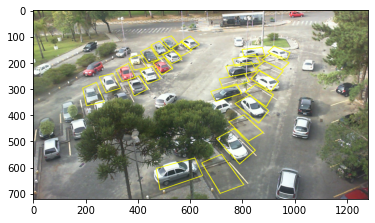

In [13]:
im = cv2.imread(IMAGE_PATH)
im2 = im.copy()
if im is None:
    sys.exit("A imagem não foi carregada.")

j=0
for i in range(len(paresXY)//4):
    cv2.polylines(im,[paresXY[j:j+4]],True,(0,255,255),2)
    crop(j,i,vaga[i])
    j=j+4

image = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
plt.imshow(image)

#cv2.imshow("Imagem completa", im)
#cv2.waitKey(0)
#cv2.destroyAllWindows()